## Estimating a rate from Poisson data: an idealized example

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy.stats import gamma


In many applications, it is convenient to extend the Poisson model for data points $y_1,\ldots,y_n$ to the form $$y_i\sim\textsf{Poisson}(x_i\theta),$$ where the value $x_i$ is called the exposure of the $i$-th unit.

If $$\theta\sim\textsf{Gamma}(\alpha,\beta),$$ then $$\theta|\mathbf{y}\sim\textsf{Gamma}\left(\alpha+\sum_{i=1}^n y_i,\beta+\sum_{i=1}^n x_i\right)$$

Suppose that 3 persons, out of a population of 200,000 died of asthma. A Poisson sampling model is often used for epidemiological data of this form. Let be $\theta$ the **asthma mortaility rate per 100,000 people per year**, and $y$ the number of deaths due to asthma in a city of 200,000 in one year, so $y|\theta\sim\textsf{Poisson}(2\theta)$.

Reviews of asthma mortality rates suggests that mortality rates above 1.5 per 100,000 people are rare, with tipycal asthma mortality rates around 0.6 per 100,000 people. Thus, for this problem we can model $\theta\sim\textsf{Gamma}(3,5)$.

Note thaty the expected value of a $\textsf{Gamma}(\alpha, \beta)$ is given by $\alpha/\beta$. Thus, we can set the expected value of the prior distribution for $\theta$ to be 0.6, that is $\alpha=0.6\beta$. Finally the value of $\beta$ can be set by trial and error so the value 1.5 be extreme.

In [2]:
with pm.Model() as poisson_model:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=2 * theta, observed=3)

    trace_poisson = pm.sample()

/tmp/ipykernel_5414/896936137.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poisson = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8823229353995699, but should be close to 0.8. Try to increase the number of tuning steps.


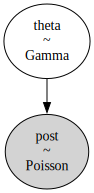

In [3]:
pm.model_to_graphviz(poisson_model)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

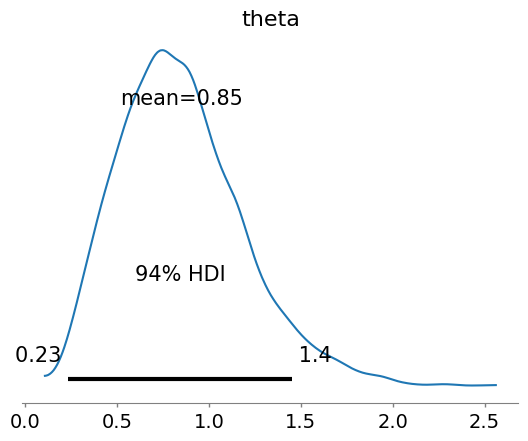

In [4]:
pm.plot_posterior(trace_poisson)

The true posterior distribution is $\textsf{Gamma}(6,7)$. Let's compare it with the one we found using `pymc3`.

In [5]:
post_poisson_summary = az.summary(trace_poisson)
post_poisson_summary

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.849,0.341,0.233,1.449,0.008,0.006,1637.0,2301.0,1.0


From the empirical mean and standard deviation of $\theta$ we can estimate the parameters of the corresponding Gamma distribution to compare with the theoretical posterior distribution. To do so, we use the method of moments, let $\bar\theta$ and $s_\theta^2$ the empirical mean and emipirical variance, respectively. Denote by $\hat\alpha$ and $\hat\beta$ the estimators a posteriori of $\alpha$ and $\beta$. We can get them solving the following equations:

$$\frac{\hat\alpha}{\hat\beta} = \bar\theta,$$
$$\frac{\hat\alpha}{\hat\beta} = s_\theta^2.$$

Yielding

$$\hat\alpha = \frac{\bar\theta^2}{s_\theta^2},$$
$$\hat\beta = \frac{\bar\theta}{s_\theta^2}.$$

In [6]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 6, scale=1/7)

mean_t = post_poisson_summary['mean'].values[0]
sd_t = post_poisson_summary['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

Text(0.5, 0, '$\\theta$')

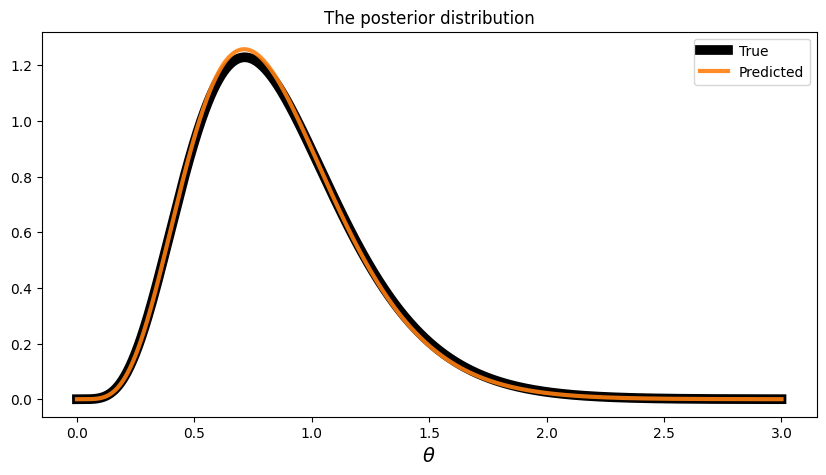

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=7)
plt.plot(x, y_pred, 'C1', label='Predicted', linewidth=3, alpha=0.9)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14)

Assume that we find 30 deaths over 10 years.

In [8]:
with pm.Model() as poisson_model_2:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=2 * 10 * theta, observed=30)

    trace_poisson_2 = pm.sample()

/tmp/ipykernel_5414/3604793767.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poisson_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

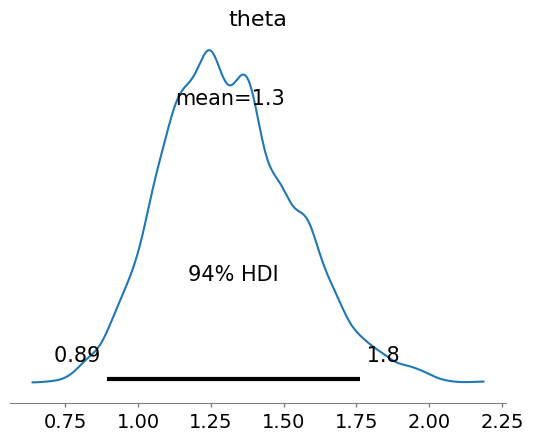

In [9]:
pm.plot_posterior(trace_poisson_2)

The true posterior distribution is $\textsf{Gamma}(33,25)$. Let's compare it with the one we found using `pymc3`.

In [10]:
post_poisson_summary_2 = az.summary(trace_poisson_2)
post_poisson_summary_2

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,1.315,0.235,0.892,1.762,0.006,0.004,1703.0,2748.0,1.0


In [11]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 33, scale=1/25)

mean_t = post_poisson_summary_2['mean'].values[0]
sd_t = post_poisson_summary_2['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

Text(0.5, 0, '$\\theta$')

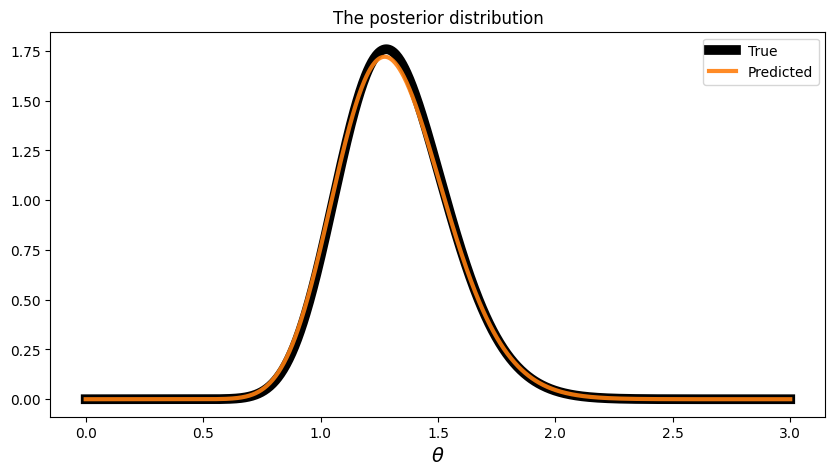

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=7)
plt.plot(x, y_pred, 'C1', label='Predicted', linewidth=3, alpha=0.9)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14)